In [1]:
# Import the necessary libraries
import os
import sys
from pathlib import Path

In [2]:
# Provide path to helper functions
current_file_path = os.path.abspath('')
root_file_path = str(Path(current_file_path).parent)
sys.path.append(root_file_path)

In [3]:
# Load the helper functions
from deep_globe_seg.helpers import list_subfolders_and_files, CFG, Dataset, get_preprocessing, get_training_augmentation, Dataloader, visualize_samples, plot_training_history

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
2024-08-18 09:48:18.554271: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 09:48:18.595134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 09:48:18.595170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 09:48:18.596680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory

In [4]:
# Define custom parameters
custom_dataset_params = {
    'img_size': (512, 512),
    'input_shape': (512, 512, 3),
}

custom_hyper_params = {
    'batch_size': 8,
    'learning_rate': 0.0001,
    'num_classes': 1,
    'epochs': 10
}

# Initialize the CFG class with custom parameters
configs = CFG(image_folder=os.path.join(root_file_path, 'data'),
                  saved_model_folder=os.path.join(root_file_path, 'saved_models'),
                  tensorboard_logs_path=os.path.join(root_file_path, 'logs'),
                  model_type='unet',
                  hyper_params= custom_hyper_params,
                  dataset_params= custom_dataset_params)

In [5]:
# Define U-Net model parameters
BACKBONE = 'resnet50'
BATCH_SIZE = configs.HyperParameter.batch_size
CLASSES = ['road']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
LR = configs.HyperParameter.learning_rate
EPOCHS = configs.HyperParameter.epochs

In [6]:
# Create the necessary folders
Path(configs.Path.saved_model_folder).mkdir(parents = True, exist_ok = True)
Path(configs.Path.tensorboard_logs_path).mkdir(parents = True, exist_ok = True)

In [7]:
# Replace 'your_base_folder_path' with the path to your base folder
list_subfolders_and_files(configs.Path.image_folder)

Subfolder: /home/jovyan/workspace/deepglobe-road-segmentation/data/valid
  100794_sat.jpg
  100905_sat.jpg
  102867_sat.jpg
  10417_sat.jpg
  106553_sat.jpg
  10678_sat.jpg
  107243_sat.jpg
  109245_sat.jpg
  11053_sat.jpg
  112600_sat.jpg
Subfolder: /home/jovyan/workspace/deepglobe-road-segmentation/data/test
  100393_sat.jpg
  100995_sat.jpg
  101982_sat.jpg
  10206_sat.jpg
  102240_sat.jpg
  102765_sat.jpg
  104859_sat.jpg
  105342_sat.jpg
  105546_sat.jpg
  105695_sat.jpg
Subfolder: /home/jovyan/workspace/deepglobe-road-segmentation/data/train
  100034_mask.png
  100034_sat.jpg
  100081_mask.png
  100081_sat.jpg
  100129_mask.png
  100129_sat.jpg
  100703_mask.png
  100703_sat.jpg
  100712_mask.png
  100712_sat.jpg


In [8]:
# Import CV packages
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A

# Import tensorflow, keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import CSVLogger

# Import image segmentation package
import os
os.environ['SM_FRAMEWORK'] = "tf.keras"
import segmentation_models as sm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Segmentation Models: using `tf.keras` framework.


In [9]:
# Read metadata and filter for training data
metadata_df = pd.read_csv(configs.Path.metadata)
metadata_df = metadata_df[metadata_df['split'] == 'train']
metadata_df = metadata_df.iloc[:1000,:]

# Select relevant columns and update paths
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(configs.Path.image_folder, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda mask_pth: os.path.join(configs.Path.image_folder, mask_pth))

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1, random_state=9).reset_index(drop=True)

# Split into train, validation, and test sets (80/10/10 split)
test_df = metadata_df.sample(frac=0.1, random_state=9)
remaining_df = metadata_df.drop(test_df.index)
valid_df = remaining_df.sample(frac=0.1, random_state=9)
train_df = remaining_df.drop(valid_df.index)

# Print informative message about dataset split
print("Dataset successfully loaded and split into training, validation, and test sets:")
print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(valid_df)}")
print(f"Number of samples in test set: {len(test_df)}")

Dataset successfully loaded and split into training, validation, and test sets:
Number of samples in training set: 810
Number of samples in validation set: 90
Number of samples in test set: 100


In [10]:
train_df.head(3)

image_id                                     sat_image_path  \
0    100129  /home/jovyan/workspace/deepglobe-road-segmenta...   
1    229193  /home/jovyan/workspace/deepglobe-road-segmenta...   
4    189835  /home/jovyan/workspace/deepglobe-road-segmenta...   

                                           mask_path  
0  /home/jovyan/workspace/deepglobe-road-segmenta...  
1  /home/jovyan/workspace/deepglobe-road-segmenta...  
4  /home/jovyan/workspace/deepglobe-road-segmenta...

In [11]:
valid_df.head(3)

image_id                                     sat_image_path  \
575    117357  /home/jovyan/workspace/deepglobe-road-segmenta...   
868    208604  /home/jovyan/workspace/deepglobe-road-segmenta...   
720    195501  /home/jovyan/workspace/deepglobe-road-segmenta...   

                                             mask_path  
575  /home/jovyan/workspace/deepglobe-road-segmenta...  
868  /home/jovyan/workspace/deepglobe-road-segmenta...  
720  /home/jovyan/workspace/deepglobe-road-segmenta...

In [12]:
test_df.head(3)

image_id                                     sat_image_path  \
2       10802  /home/jovyan/workspace/deepglobe-road-segmenta...   
879    228246  /home/jovyan/workspace/deepglobe-road-segmenta...   
57     183397  /home/jovyan/workspace/deepglobe-road-segmenta...   

                                             mask_path  
2    /home/jovyan/workspace/deepglobe-road-segmenta...  
879  /home/jovyan/workspace/deepglobe-road-segmenta...  
57   /home/jovyan/workspace/deepglobe-road-segmenta...

In [13]:
# Get class dictionary  
class_dict = pd.read_csv(configs.Path.class_dict)
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [14]:
# Load the pre-processing function for the chosen model
preprocess_input = sm.get_preprocessing(BACKBONE)

In [41]:
# Dataset for train images
train_dataset = Dataset(
    train_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input),
    augmentation=get_training_augmentation(configs.Dataset.img_size)
)

# Dataset for validation images
valid_dataset = Dataset(
    valid_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input)
)

# Dataset for test images
test_dataset = Dataset(
    test_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input)
)

# Dataloader for training and validation images
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

INFO:root:Initialized Dataset with 810 samples.
INFO:root:Initialized Dataset with 90 samples.
INFO:root:Initialized Dataset with 100 samples.


In [16]:
# Check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, *configs.Dataset.img_size, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, *configs.Dataset.img_size, n_classes)

2024-08-18 09:48:20.752931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-18 09:48:20.805359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-18 09:48:20.805609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
# Sample images from training and validation sets
sample_training_images = [train_dataset[i] for i in range(10)]
sample_validation_images = [valid_dataset[i] for i in range(10)]

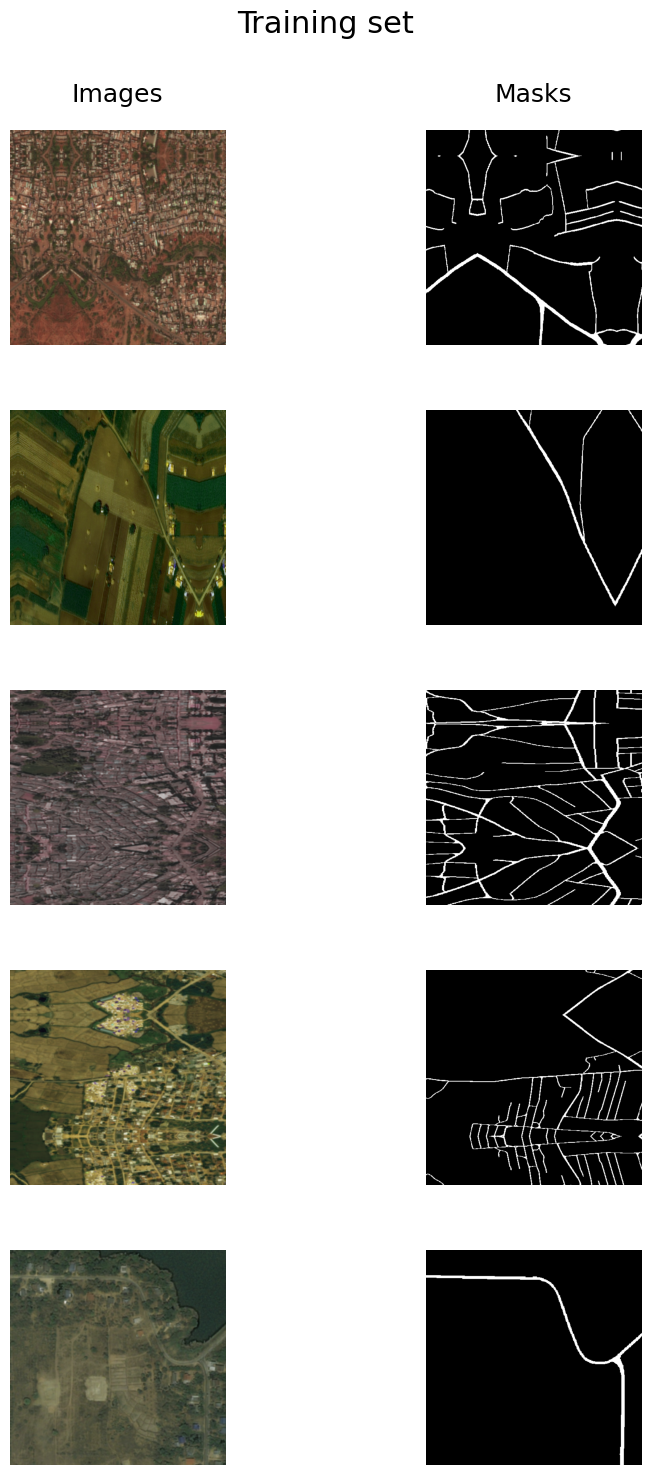

In [18]:
# Visualize training images
visualize_samples(sample_training_images, num_samples=5, figsize=(10, 3*5), figtitle="Training set")

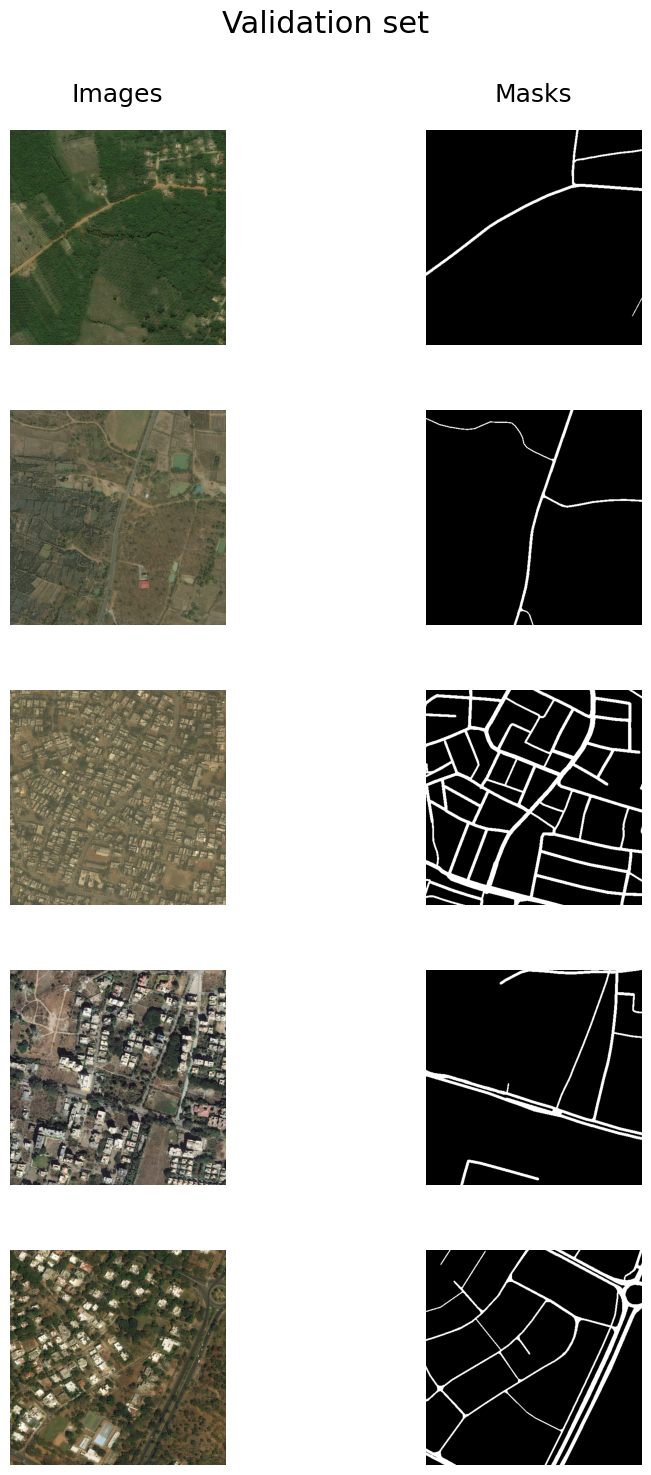

In [19]:
# Visualize validation images
visualize_samples(sample_validation_images, num_samples=5, figsize=(10, 3*5), figtitle="Validation set")

In [20]:
# Define network parameters
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# Create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [21]:
# Define optomizer
optim = keras.optimizers.Adam(LR)

# Define loss function
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Evaluation metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
metrics_names = ["IOU","F"]

# Compile keras model with defined optimizer, loss and metrics inputs
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [22]:
# Define callbacks for learning rate scheduling, best checkpoints saving and log of training process
callbacks = [
    CSVLogger(os.path.join(configs.Path.tensorboard_logs_path,'training_log.csv'), append=True, separator=';'),
    keras.callbacks.ModelCheckpoint(configs.Path.model_save_path, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  patience=3,
                                  verbose=1, 
                                  mode='min',
                                  restore_best_weights=True)
]

In [24]:
run = True

In [25]:
# Train model
if run:
    if os.path.isfile(configs.Path.model_save_path):
        print("INFO ===========Running the Partially Trained Model===============")
        model.load_weights(configs.Path.model_save_path)
        history = model.fit(
            train_dataloader,
            epochs=EPOCHS,
            callbacks=callbacks, 
            validation_data=valid_dataloader,
            verbose=1
        )
    else:
        print("INFO ===========Running the Training of Model from Scratch===============")
        history = model.fit(
            train_dataloader, 
            epochs=EPOCHS,
            callbacks=callbacks, 
            validation_data=valid_dataloader,
            verbose=1
        )

INFO ===========Running the Partially Trained Model===============
Epoch 1/10


I0000 00:00:1723974552.768444    1347 service.cc:145] XLA service 0x7f76b4001690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723974552.768484    1347 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-18 09:49:13.589658: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-18 09:49:16.492634: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-08-18 09:49:25.378797: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-18 09:49:28.366488: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0

 62/102 ━━━━━━━━━━━━━━━━━━━━ 23s 585ms/step - f1-score: 0.6065 - iou_score: 0.4372 - loss: 0.4780

I0000 00:00:1723974684.669421    1347 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_1', 280 bytes spill stores, 276 bytes spill loads



102/102 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - f1-score: 0.6066 - iou_score: 0.4375 - loss: 0.4768 - val_f1-score: 0.5746 - val_iou_score: 0.4282 - val_loss: 0.4955 - learning_rate: 1.0000e-04
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 636ms/step - f1-score: 0.6179 - iou_score: 0.4490 - loss: 0.4533 - val_f1-score: 0.5754 - val_iou_score: 0.4290 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 638ms/step - f1-score: 0.6043 - iou_score: 0.4370 - loss: 0.4642 - val_f1-score: 0.6302 - val_iou_score: 0.4740 - val_loss: 0.4362 - learning_rate: 1.0000e-04
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 607ms/step - f1-score: 0.6255 - iou_score: 0.4576 - loss: 0.4374 - val_f1-score: 0.5851 - val_iou_score: 0.4380 - val_loss: 0.4684 - learning_rate: 1.0000e-04
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 638ms/step - f1-score: 0.6277 - iou_score: 0.4597 - loss: 0.4349 - val_f1-score: 0.6270 - val_iou_score: 0.4742 - val_loss: 0.4318 - learning_rate: 1.0000e-0

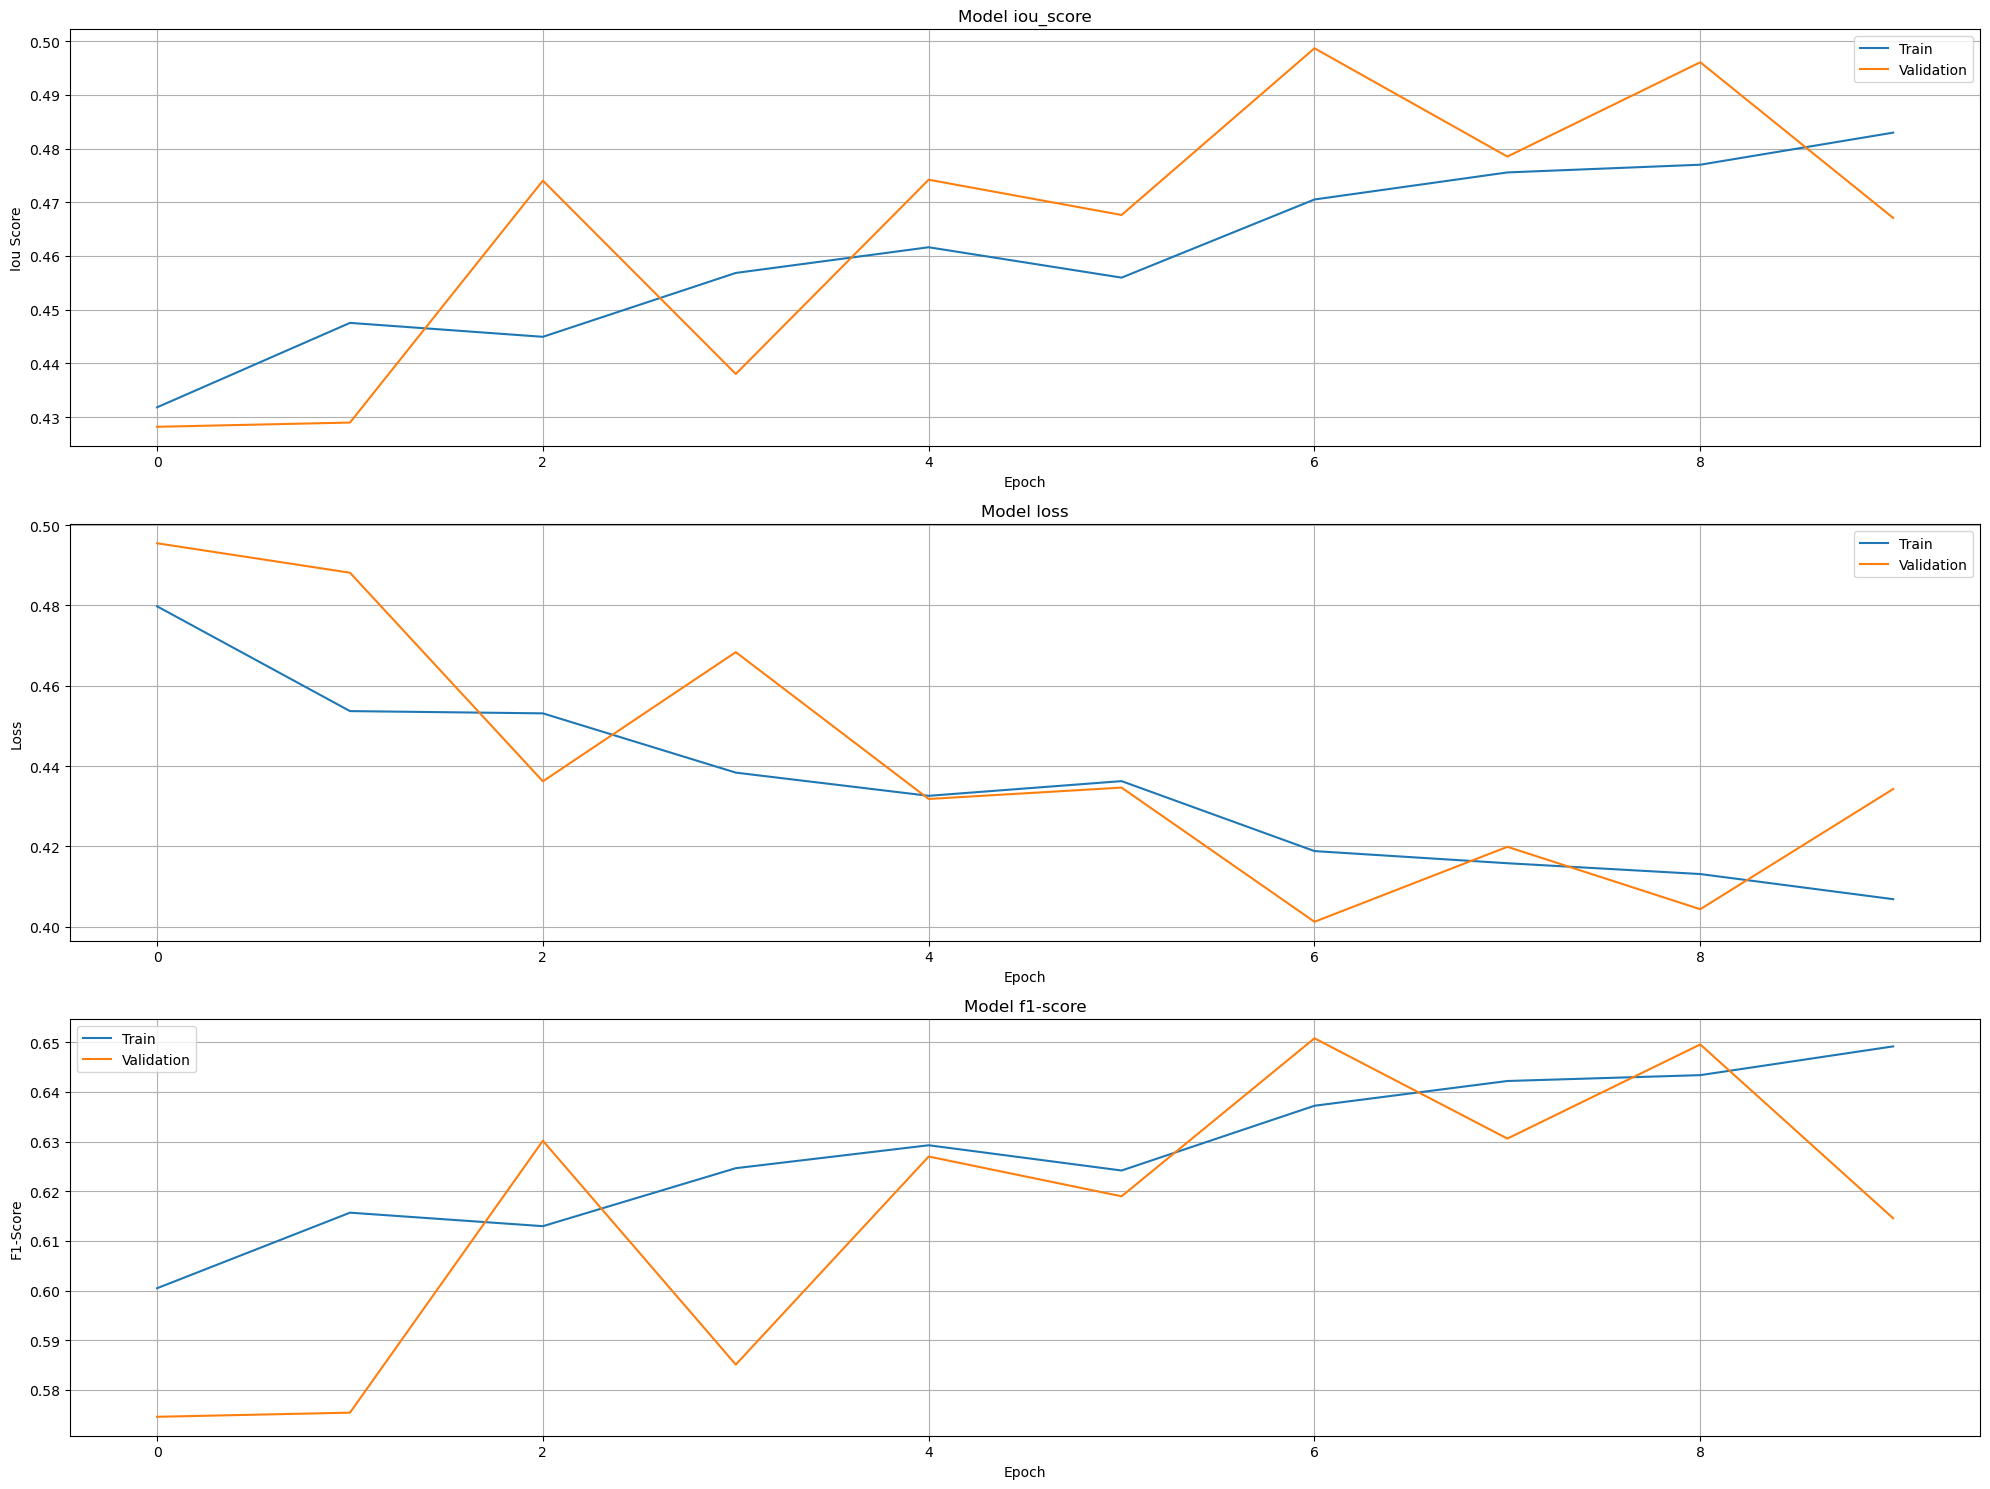

In [26]:
# Plot training history
if run:
    plot_training_history(history, ['iou_score', 'loss', 'f1-score'])

In [27]:
# Load weights
if not run and os.path.isfile(configs.Path.model_save_path):
    model.load_weights(cfg.Path.model_save_path) 

In [40]:
# Evaluate on the training set
train_results = model.evaluate(train_dataloader, verbose=1)

# Print the results
print("Training results:")
for metric_name, metric_value in zip(['loss'] + metrics_names, train_results):
    print(f"{metric_name}: {metric_value}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - f1-score: 0.6614 - iou_score: 0.4961 - loss: 0.3941
Training results:
loss: 0.39525535702705383
IOU: 0.49548396468162537
F: 0.6607325673103333


In [39]:
# Evaluate on the validation set
val_results = model.evaluate(valid_dataloader, verbose=1)

# Print the results
print("Validation results:")
for metric_name, metric_value in zip(['loss'] + metrics_names, val_results):
    print(f"{metric_name}: {metric_value}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - f1-score: 0.6405 - iou_score: 0.4875 - loss: 0.4128
Validation results:
loss: 0.4012463390827179
IOU: 0.4986843466758728
F: 0.6508264541625977


In [42]:
# Evaluate on the test set
test_results = model.evaluate(test_dataloader, verbose=1)

# Print the results
print("Validation results:")
for metric_name, metric_value in zip(['loss'] + metrics_names, test_results):
    print(f"{metric_name}: {metric_value}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - f1-score: 0.6268 - iou_score: 0.4768 - loss: 0.4293
Validation results:
loss: 0.44285833835601807
IOU: 0.4611976742744446
F: 0.61085444688797


In [43]:
# Generate test predictions
test_predictions = model.predict(test_dataloader, verbose=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


In [93]:
# Prepare three layers for visualization
test_samples = [test_dataloader[i] for i in range(len(test_dataloader))]
test_images, test_masks = zip(*test_samples)
test_images = np.clip(tf.squeeze(test_images, axis=1).numpy(), 0, 255).astype(np.uint8)
test_masks = tf.squeeze(test_masks, axis=1).numpy()

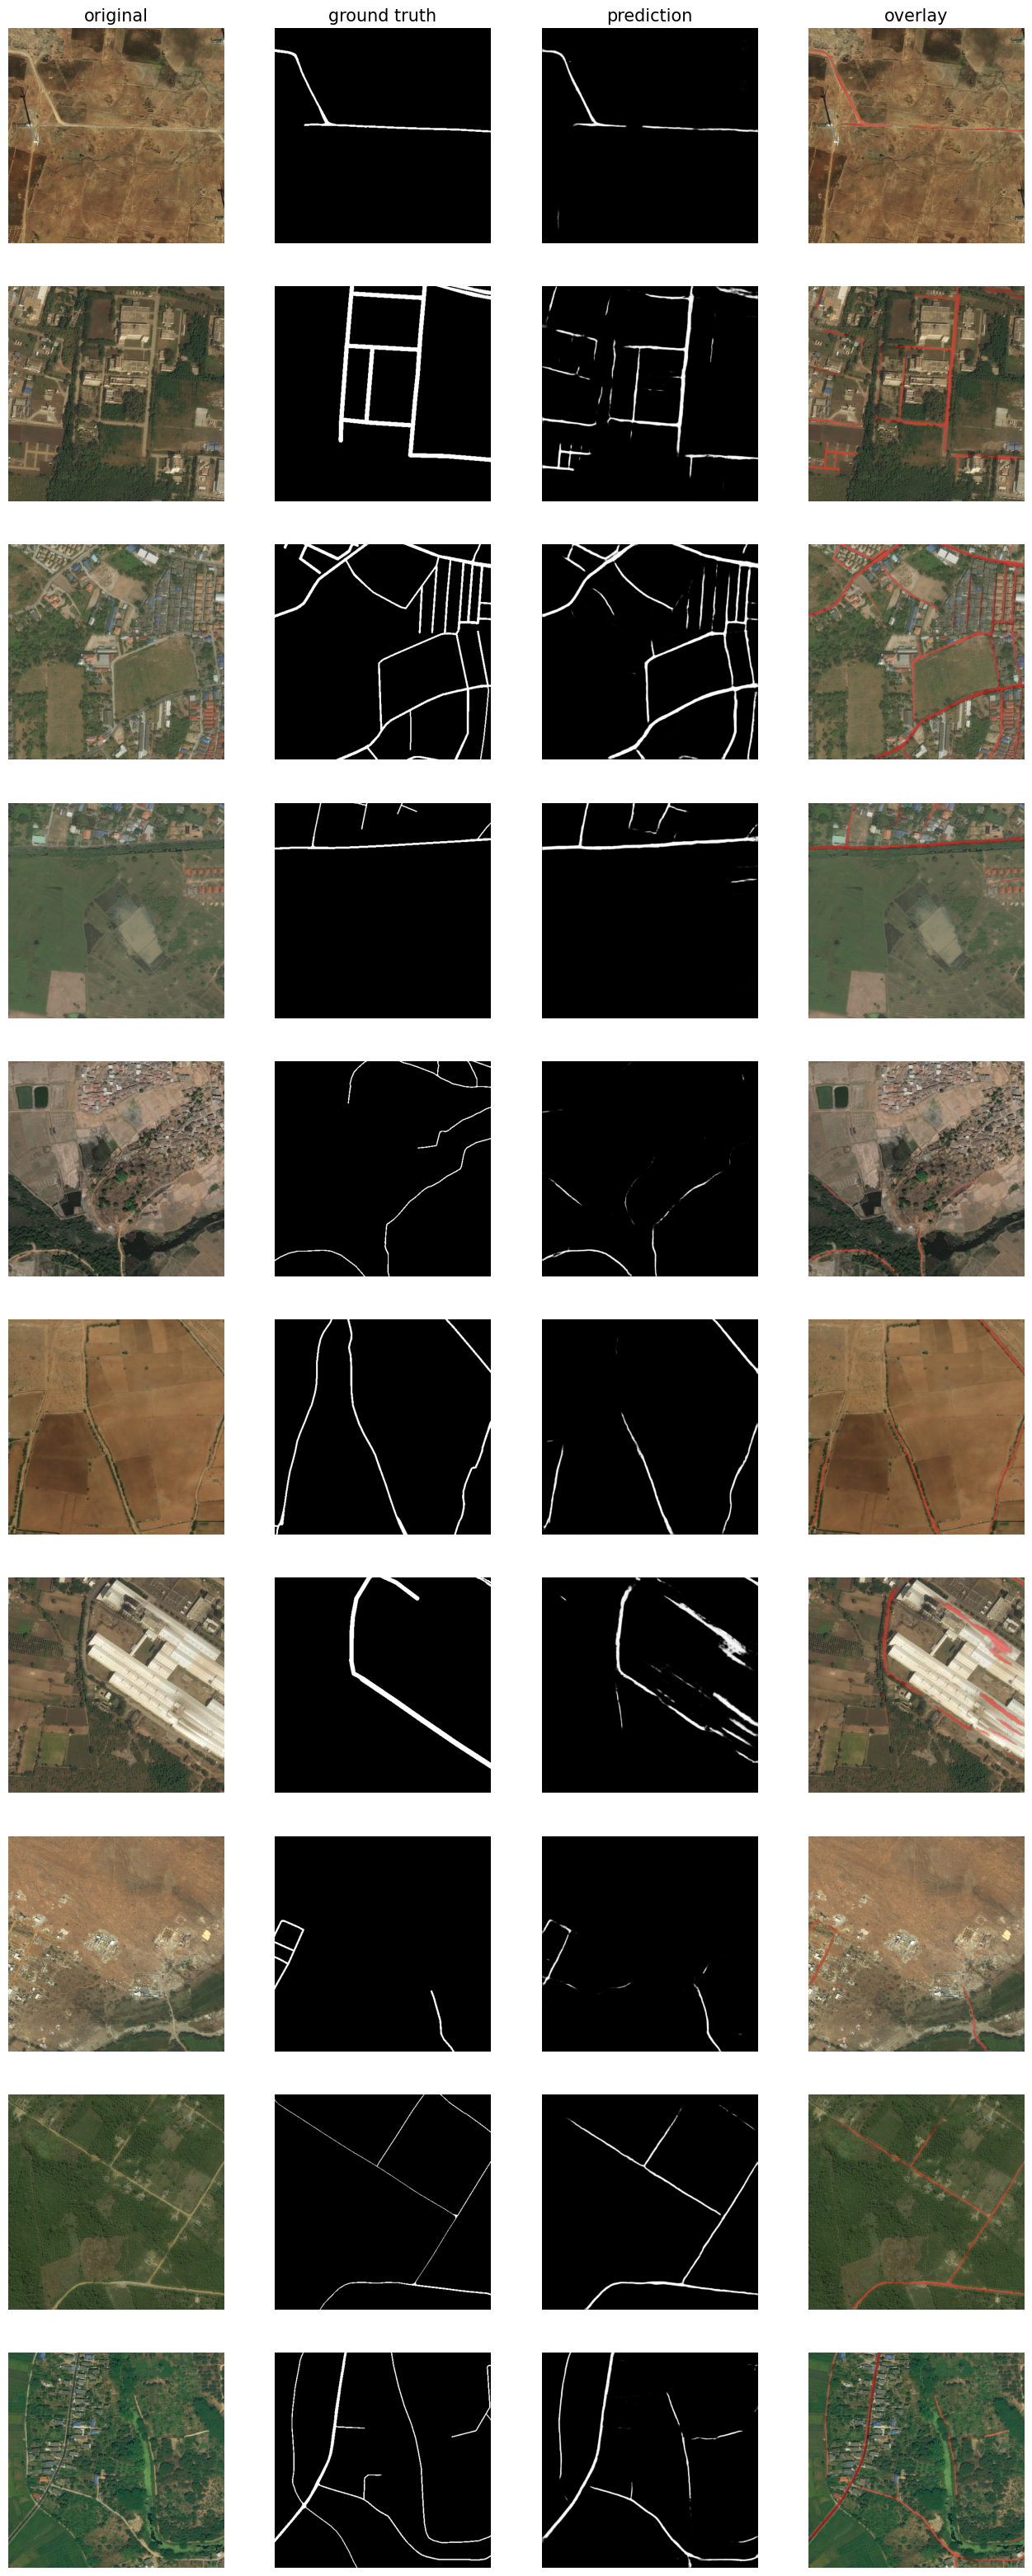

In [94]:
# Overlay original test images with predictions
from keras_unet.utils import plot_imgs
plot_imgs(org_imgs=test_images,
          mask_imgs=test_masks,
          pred_imgs=test_predictions, nm_img_to_plot=10)